In [1]:
!git init .
!git remote add -t \* -f origin https://github.com/gorodnitskiy/coco_utils.git
!git checkout master

Initialized empty Git repository in /content/.git/
Updating origin
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 53 (delta 1), reused 53 (delta 1), pack-reused 0
Unpacking objects: 100% (53/53), done.
From https://github.com/gorodnitskiy/coco_utils
 * [new branch]      master     -> origin/master
Branch 'master' set up to track remote branch 'master' from 'origin'.
Already on 'master'


In [2]:
import numpy as np

import torchvision
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from dataset import OpenImagesDataset, collate_fn
from vizualization import visualize_from_dataset, visualize, visualize_prediction_plate
from supported import freeze_seed, set_max_threads

from engine import evaluate
from training_loop import train_one_epoch

## Freeze seeds and set max threads

In [3]:
freeze_seed()
set_max_threads()

## Load datasets

In [8]:
root = "openimages"
class_names = ["Duck"]

img_transforms = transforms.Compose([
    transforms.RandomChoice([
        transforms.ColorJitter(brightness=0.5),
        transforms.ColorJitter(contrast=0.5),
        transforms.ColorJitter(saturation=0.5),
        transforms.ColorJitter(hue=0.5),
        transforms.RandomGrayscale(p=0.5),
        transforms.GaussianBlur(3, sigma=(0.1, 5.0))]),
    transforms.ToTensor(),
])

img_transforms_test = transforms.Compose([
    transforms.ToTensor(),
])

In [9]:
train_dataset = OpenImagesDataset(
    root=root, 
    part="train", 
    class_names=class_names, 
    transforms=img_transforms)

val_dataset = OpenImagesDataset(
    root=root, 
    part="validation", 
    class_names=class_names, 
    transforms=img_transforms)

test_dataset = OpenImagesDataset(
    root=root, 
    part="test", 
    class_names=class_names, 
    transforms=img_transforms_test)

installing boto3 and botocore for downloader by openimages ...
     |████████████████████████████████| 133kB 16.3MB/s 
     |████████████████████████████████| 71kB 10.0MB/s 
     |████████████████████████████████| 7.3MB 27.2MB/s 
     |████████████████████████████████| 143kB 70.4MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


## Visualization sample from dataset

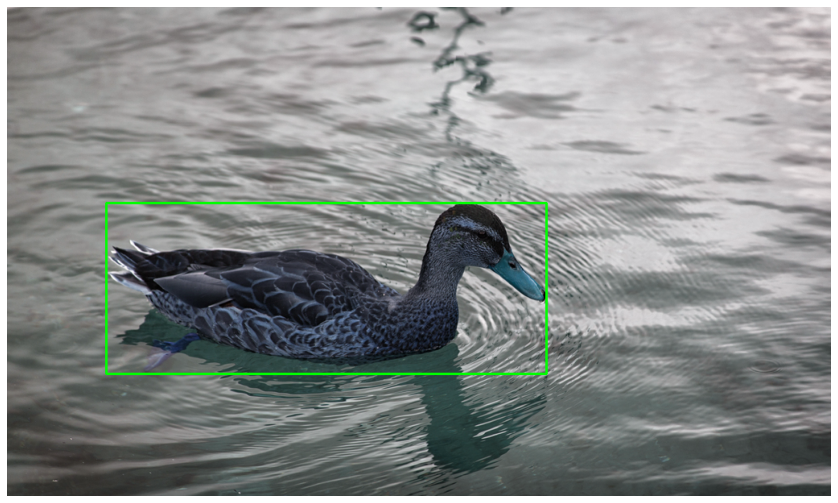

In [154]:
visualize_from_dataset(test_dataset[45])

## Make dataloaders

In [13]:
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=8, 
    shuffle=True, 
    num_workers=16,
    collate_fn=collate_fn, 
    drop_last=True)

data_loader_val = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=8, 
    shuffle=False, 
    num_workers=16,
    collate_fn=collate_fn, 
    drop_last=False)

data_loader_test = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=8, 
    shuffle=False, 
    num_workers=16,
    collate_fn=collate_fn, 
    drop_last=False)

## Load model (Faster R-CNN with ResNet50 backbone and FPN)

In [16]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=True)

num_classes = 2 # Duck and background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

assert model.roi_heads.box_predictor.cls_score.in_features == 1024
assert model.roi_heads.box_predictor.cls_score.out_features == 2
assert model.roi_heads.box_predictor.bbox_pred.out_features == 8

In [18]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Turn-on training only for region-proposal and classification-regression head
for param in model.parameters():
    param.requires_grad = False
    
for param in model.rpn.parameters():
    param.requires_grad = True
    
for param in model.roi_heads.parameters():
    param.requires_grad = True

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params, 
    lr=0.005,
    momentum=0.9, 
    weight_decay=0.0005
)

# construct an scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=30,
    gamma=0.1
)

## Turn-on training loop

In [22]:
num_epochs = 100

for epoch in range(num_epochs):
    train_one_epoch(
        model=model, 
        optimizer=optimizer,
        lr_scheduler=lr_scheduler,
        data_loader=data_loader,
        device=device, 
        epoch=epoch,
        print_freq=50)
    
#     lr_scheduler.step()
    evaluate(model, data_loader_val, device=device)
    torch.save(model.state_dict(), 'model_state_dict_last.pth')

Epoch: [0]  [  0/721]  eta: 1:06:47  lr: 0.000012  loss: 1.0311 (1.0311)  loss_classifier: 0.5289 (0.5289)  loss_box_reg: 0.4372 (0.4372)  loss_objectness: 0.0494 (0.0494)  loss_rpn_box_reg: 0.0157 (0.0157)  time: 5.5579  data: 3.6639
Epoch: [0]  [ 50/721]  eta: 0:10:35  lr: 0.000359  loss: 0.6291 (0.8669)  loss_classifier: 0.2176 (0.3320)  loss_box_reg: 0.3412 (0.3838)  loss_objectness: 0.0500 (0.1193)  loss_rpn_box_reg: 0.0207 (0.0318)  time: 0.8107  data: 0.0246
Epoch: [0]  [100/721]  eta: 0:09:20  lr: 0.000706  loss: 0.6875 (0.7501)  loss_classifier: 0.1788 (0.2523)  loss_box_reg: 0.3274 (0.3502)  loss_objectness: 0.0804 (0.1147)  loss_rpn_box_reg: 0.0304 (0.0328)  time: 0.9119  data: 0.0340
Epoch: [0]  [150/721]  eta: 0:08:28  lr: 0.001053  loss: 0.4098 (0.6629)  loss_classifier: 0.1284 (0.2177)  loss_box_reg: 0.1766 (0.3137)  loss_objectness: 0.0332 (0.0996)  loss_rpn_box_reg: 0.0279 (0.0320)  time: 0.9191  data: 0.0226
Epoch: [0]  [200/721]  eta: 0:07:42  lr: 0.001399  loss: 0.4

Process Process-48:
Process Process-37:
Process Process-33:
Process Process-46:
Process Process-45:
Process Process-39:
Process Process-43:
Process Process-41:
Process Process-36:
Process Process-38:
Process Process-34:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 300, in _bootstrap
    util._exit_function()
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 300, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 300, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 300, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.7/multiprocessin

KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(), 'model_state_dict_workshop_final.pth')

In [ ]:
model.load_state_dict(torch.load('model_state_dict_final.pth'))
model.to(device)
evaluate(model, data_loader_val, device=device)

# Vizualize predictions for validation set

Class: plate, Confidence: 0.9775582551956177
Class: plate, Confidence: 0.9517622590065002


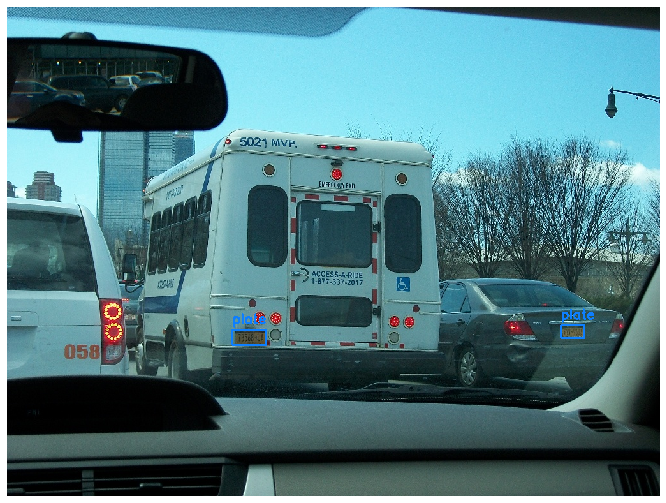

{'boxes': tensor([[ 868.0917,  500.7053,  905.4838,  520.8012],
         [ 353.5850,  507.3642,  406.7459,  531.3723],
         [  87.2286,  524.4083,  142.5963,  558.9417],
         [ 942.9408,  718.9457, 1016.0476,  768.0000],
         [ 456.3982,  412.0817,  565.5555,  440.9790]], device='cuda:0'),
 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'),
 'scores': tensor([0.9776, 0.9518, 0.4104, 0.2816, 0.0674], device='cuda:0')}

In [ ]:
idx = np.random.choice(range(len(len(data_loader_test))))
visualize_prediction_plate(idx, data_loader_test, model, id_to_name={1: 'plate'}, thresh=0.5)